In [20]:
import os
import act
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd

In [21]:

username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

ecor_kp = 'guc30ecorS3.b1'
sebs = 'gucsebsS3.b1'
ld = 'gucldM1.b1'
output_dir = os.path.join('/Users/elischwat/Development/data/sublimationofsnow', ld)

start_date = "2022-12-12"
end_date = "2022-12-14"

In [9]:
files = act.discovery.download_arm_data(
    username,
    token,
    ld,
    start_date,
    end_date,
    output=output_dir
)
disdro_ds = xr.open_mfdataset(files)

[DOWNLOADING] gucldM1.b1.20221212.000000.cdf
[DOWNLOADING] gucldM1.b1.20221213.000000.cdf
[DOWNLOADING] gucldM1.b1.20221214.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Zhu, Z., & Shi, Y. Laser Disdrometer (LD). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1973058



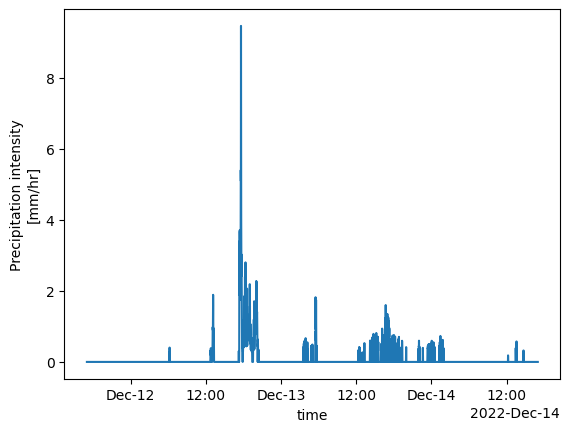

In [24]:
from sublimpy import utils
src = utils.modify_xarray_timezone(
    disdro_ds,
    'UTC',
    'US/Mountain'
)
src.precip_rate.plot()

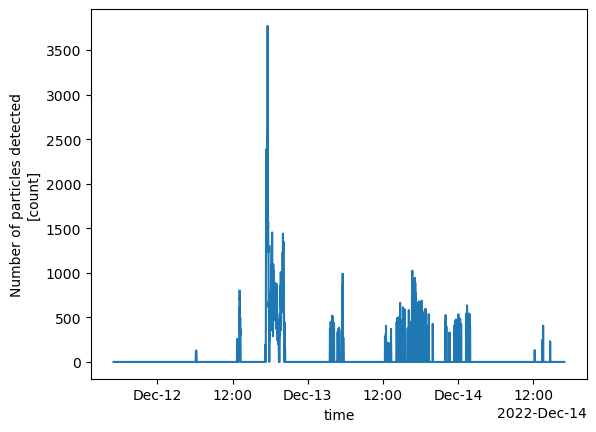

In [40]:
src['number_detected_particles'].plot(hue='particle_size')

In [14]:
disdro_df = disdro_ds.to_dataframe().reset_index()

In [15]:
disdro_precip_rate_df = pd.DataFrame(
    disdro_df.groupby("time")['precip_rate'].max()
).reset_index()

In [71]:
disdro_precip_rate_30min_df = disdro_precip_rate_df.set_index(
    "time"
).resample(
    "1440Min"
).max().reset_index()

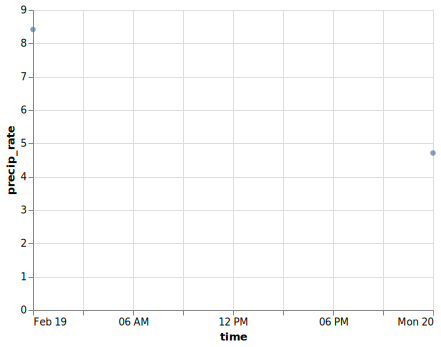

In [72]:
alt.Chart(disdro_precip_rate_30min_df).mark_circle().encode(
    alt.X('time:T'),
    alt.Y("precip_rate:Q")
)

In [73]:
s = disdro_precip_rate_30min_df.groupby(disdro_precip_rate_30min_df['precip_rate'].ne(0).cumsum())['time'].transform('first')
disdro_precip_rate_30min_df['days_since_precip'] = (disdro_precip_rate_30min_df['time'] - s).dt.days

In [74]:
disdro_precip_rate_30min_df

,time,precip_rate,days_since_precip
0,2023-02-19,8.415,0
1,2023-02-20,4.710,0


WARN Dropping {} from channel "strokeDash" since it does not contain any data field, datum, value, or signal.


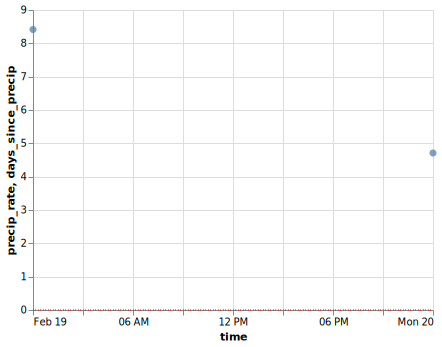

In [75]:
alt.Chart(disdro_precip_rate_30min_df).mark_circle(size=50).encode(
    alt.X('time:T'),
    alt.Y("precip_rate:Q")
) + alt.Chart(disdro_precip_rate_30min_df).mark_line(color='red', strokeDash=[0.5,2]).encode(
    alt.X('time:T'),
    alt.Y("days_since_precip:Q"),
    alt.StrokeDash()
)

# Look at high rate data for a day


In [76]:
import sys
sys.path.append("/home/elilouis/sublimationofsnow/")
import sosutils

In [77]:
disdro_ds

<xarray.Dataset>
Dimensions:                               (time: 2880, particle_size: 32,
                                           raw_fall_velocity: 32)
Coordinates:
  * time                                  (time) datetime64[ns] 2023-02-19 .....
  * particle_size                         (particle_size) float32 0.062 ... 24.0
  * raw_fall_velocity                     (raw_fall_velocity) float32 0.05 .....
Data variables: (12/42)
    base_time                             (time) datetime64[ns] 2023-02-19 .....
    time_offset                           (time) datetime64[ns] dask.array<chunksize=(1440,), meta=np.ndarray>
    precip_rate                           (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_precip_rate                        (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    weather_code                          (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_weather_code                       (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                                    ...
    moment4                               (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    moment5                               (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    moment6                               (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                                   (time) float32 38.96 38.96 ... 38.96
    lon                                   (time) float32 -107.0 ... -107.0
    alt                                   (time) float32 2.886e+03 ... 2.886e+03
Attributes: (12/15)
    command_line:                ld_ingest -s guc -f M1
    process_version:             ingest-ld-1.4-0.el7
    dod_version:                 ld-b1-2.0
    Conventions:                 ARM-1.2
    data_level:                  b1
    platform_id:                 ld
    ...                          ...
    facility_id:                 M1
    sampling_interval:           1 minute
    effective_measurement_area:  0.54 m^2
    doi:                         10.5439/1560674
    datastream:                  gucldM1.b1
    history:                     created by user dsmgr on machine prod-proc4....

In [78]:
alt.renderers.enable("svg")

RendererRegistry.enable('svg')

In [81]:
src = disdro_precip_rate_df.copy()
src = sosutils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src = src[src.time.dt.day==19]

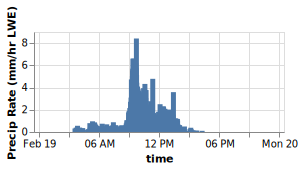

In [82]:

alt.Chart(src).mark_bar().encode(
    alt.X("time:T"),
    alt.Y("precip_rate:Q", title='Precip Rate (mm/hr LWE)')
).properties(width=250, height=100)